In [1]:
%%capture
!pip install timm

In [2]:
import time
from tqdm import tqdm_notebook as tqdm
#import tqdm.notebook import tqdm
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
import timm
import warnings
warnings.filterwarnings('ignore')

In [3]:
!ls -l ../input/midsw251birds

total 1244
-rw-r--r-- 1 nobody nogroup   5062 Aug  6 17:40 metadata.csv
-rw-r--r-- 1 nobody nogroup 197871 Aug  6 17:40 sample_submission.csv
drwxr-xr-x 2 nobody nogroup      0 Aug  6 17:41 test
-rw-r--r-- 1 nobody nogroup 181377 Aug  6 17:40 test.csv
drwxr-xr-x 2 nobody nogroup      0 Aug  6 17:43 train
-rw-r--r-- 1 nobody nogroup 876817 Aug  6 17:41 train.csv


In [4]:
class args:
    lr = 0.0001
    epochs = 5
    batch_size = 96
    num_workers = 8
    folds = 5

In [5]:
alldf = pd.read_csv('../input/midsw251birds/train.csv')
# Split the training dataset into a training and a validation
valdf = alldf[::args.folds]
trndf = alldf[~alldf.filename.isin(valdf.filename)]
# Load our test data
tstdf = pd.read_csv('../input/midsw251birds/test.csv')
metadf = pd.read_csv('../input/midsw251birds/metadata.csv')
metadf = metadf.set_index('label')
print(f'File shapes -- train : {trndf.shape}, valid : {valdf.shape}, test : {tstdf.shape}')
trndf.head()

File shapes -- train : (26379, 2), valid : (6595, 2), test : (8244, 1)


,filename,label
1,train/bb99f4bea973.jpg,147
2,train/50923ceb3ffd.jpg,147
3,train/f9fc3c6da5d7.jpg,147
4,train/dfe8cb1855fe.jpg,147
6,train/4fe53a096533.jpg,147


In [6]:
imgnetmeans = [0.22363983, 0.18190407, 0.2523437 ]
imgnetstds = [0.32451536, 0.2956294,  0.31335256]
# Using albumentations, check some examples here : https://albumentations.readthedocs.io/en/latest/examples.html 
def trntransforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Transpose(p=0.5),
        ToTensorV2(),
        ])

def tsttransforms():
    return A.Compose([
        ToTensorV2(),
    ])

class BirdDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        self.data = df
        self.img_dir = '../input/midsw251birds/'
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        fname = self.data.iloc[idx]['filename']
        img_path = f'{self.img_dir}/{fname}'
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image = image)['image']
        image = image.float() / 255.
        label = -1 if self.mode=='test' else self.data.iloc[idx]['label']
        
        return image, label

In [7]:
# Define our dataset
trndataset = BirdDataset(trndf, 'train', trntransforms())
valdataset = BirdDataset(valdf, 'valid', tsttransforms())
tstdataset = BirdDataset(tstdf, 'test', tsttransforms())

Species : KOOKABURRA


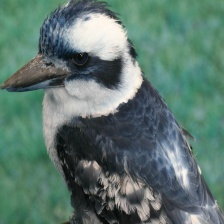

In [8]:
# Test the dataset
img, label = next(iter(trndataset))
species = metadf.loc[label]['name']
print(f'Species : {species}')
#Image.fromarray(img)
imgviz = (img * 255).transpose(0, 2).numpy().astype(np.uint8)
Image.fromarray(imgviz)

In [9]:
loaderargs = {'num_workers' : args.num_workers, 'batch_size':args.batch_size, 'pin_memory': False, 'drop_last': False}
trnloader = DataLoader(trndataset, shuffle = True, **loaderargs)
valloader = DataLoader(valdataset, shuffle = False, **loaderargs)
tstloader = DataLoader(tstdataset, shuffle = False, **loaderargs)

In [17]:
# creates efficientnet-b0 architecture
device = torch.device("cuda:0")
model = timm.create_model('efficientnet_b2', pretrained = True)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
# Loss function
criterion = torch.nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=10)
num_epochs = args.epochs

In [11]:
# https://github.com/pytorch/pytorch/issues/7455#issuecomment-759175034
import torch
import torch.nn.functional as F
from torch.nn.modules.loss import _WeightedLoss


class LabelSmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth_one_hot(targets: torch.Tensor, n_classes: int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = torch.empty(size=(targets.size(0), n_classes),
                                  device=targets.device) \
                .fill_(smoothing / (n_classes - 1)) \
                .scatter_(1, targets.data.unsqueeze(1), 1. - smoothing)
        return targets

    def forward(self, inputs, targets):
        targets = LabelSmoothCrossEntropyLoss._smooth_one_hot(targets, inputs.size(-1),
                                                              self.smoothing)
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()

        return loss

loss_function = LabelSmoothCrossEntropyLoss(smoothing=0.3)

# loss = loss_function(inputs, targets)

In [15]:
# # Create a scheduler which will warmup and cooldown over num_epochs epochs.
# # warmup is 1 epoch only

# from timm.scheduler.cosine_lr import CosineLRScheduler
# # num_epochs = 4 # laxy variable connectivity
# n_epochs = num_epochs 
# n_warmup_epochs = 1
# n_steps = len(trnloader)

# scheduler = CosineLRScheduler(
#             optimizer,
#             t_initial= n_steps * n_epochs + 1,
#             lr_min=0.00001,
#             warmup_lr_init=0.00001,
#             warmup_t= n_steps * n_warmup_epochs + 1)

In [19]:
# For mixup
beta = 1.0

since = time.time()

global_step = 0
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    scheduler.step()
    global_step +=1
    model.train()
    running_loss = 0.0
    tk0 = tqdm(trnloader, total=int(len(trnloader)))
    for step, batch in enumerate(tk0):
        inputs = batch[0].to(device, dtype=torch.float)
        labels = batch[1].to(device).long()
        
        # Mixup from the "Fork me code"
        # Get out a random value form a distribution    
        lam = np.random.beta(beta, beta)
        rand_index = torch.randperm(inputs.size()[0]).to(device) # make an index which reorders the batch

        # Reorder the labels
        labels_a = labels
        labels_b = labels[rand_index]

        # Partially mixup up the batch
        inputs_mixed = lam * inputs + (1 - lam) * inputs[rand_index]


        
        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        tk0.set_postfix(train_loss=(running_loss / (step+1)))
        
    valpreds = []
    model.eval()
    running_loss = 0.0
    tkval = tqdm(valloader, total=int(len(valloader)))
    for step, batch in enumerate(tkval):
        inputs = batch[0].to(device, dtype=torch.float)
        labels = batch[1].to(device).long()
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        valpreds .append(outputs)
        running_loss += loss.item()
        tkval.set_postfix(valid_loss=(running_loss / (step+1)))
    preds = torch.cat(valpreds).argmax(1).detach().cpu().numpy()
    print(f'Valid accuracy {(valdf.label.values == preds).mean():.4f}')

Epoch 0/4


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.8561
Epoch 1/4


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9168
Epoch 2/4


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9319
Epoch 3/4


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9433
Epoch 4/4


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9504


In [20]:
# Submit 
tstpreds = []
tktst = tqdm(tstloader, total=int(len(tstloader)))
for step, batch in enumerate(tktst):
    inputs = batch[0].to(device, dtype=torch.float)
    with torch.no_grad():
        outputs = model(inputs)
        tstpreds.append(outputs)
predicted_labels = torch.cat(tstpreds).argmax(1).detach().cpu().numpy()
tstdf['label'] = predicted_labels

  0%|          | 0/86 [00:00<?, ?it/s]

In [21]:
tstdf.to_csv('submission.csv', index = False)